## Tutorial on automatically computing Centrality

This tutorial will teach you about computing centrality. Centrality determines the **importance of an proposition**.
The centrality of a **proposition within an argument network** can be computed by **using different similarity measures**. **TextRank** is used to get the n most central propositions.

This tutorial covers 
1. Centrality computed by using the Similarity Measure of *Mihalcea an Tarau (2004)*
2. Centrality computed by doc2vec to increase performance.

##### Disclaimer: "This notebook is written  in favor of readability! It is NOT optimized towards efficency!"

### 0. Get everything ready
-----------------------------------

In [ ]:
# install all libraries if necessary
!pip install nltk
!pip install networkx
!pip install scipy
!pip install gensim
!pip install scikit-learn

In [ ]:
# import all libraries used in this tutorial
import collections
import json
import math
import networkx as nx
import nltk
import numpy as np
import operator
import os
import pandas as pd
import pickle
import random
import string 
from gensim import utils
from gensim.models import KeyedVectors
from nltk.stem import PorterStemmer
from scipy import stats
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score

In [ ]:
# install nltk components if necessary
import nltk
nltk.download('punkt')
nltk.download('stopwords')

Please download the pre-traiend word2vec vectors from https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download and save them in __./data/GoogleNews-vectors-negative300.bin__

In [ ]:
# set seeding to ensure everybody gets the correct results
random.seed(42)

### 1. Centrality computed by using the Similarity Measure of *Mihalcea an Tarau (2004)*
-----------------------------------

#### Read the data

The data is structured in the __Argument Interchange Format(AIF)__ format that you can see below. 

For our purpose only nodes of type "I" are important, as they contain propositional information for arguments such as premise or conclusion.

![alt text](aif.png)



Taken from: LAWRENCE, John; REED, Chris. Using complex argumentative interactions to reconstruct the argumentative structure of large-scale debates. In: Proceedings of the 4th Workshop on Argument Mining. 2017. S. 108-117.

In [ ]:
# read in the nodesets
# choose the I-nodes for computation and save the corresponding text
directory = os.path.join(os.getcwd(),'US2016R1reddit')
I_nodes = {}
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".json"):
        with open(os.path.join(directory,filename), 'r') as json_file:
            json_data = json.load(json_file)
            for i in range(len(json_data['nodes'])):
                if json_data['nodes'][i]['type'] == "I":
                    nodeID = json_data['nodes'][i]['nodeID']  
                    I_nodes[nodeID] = json_data['nodes'][i]['text']

# create a pandas dataframe for the data
df = pd.DataFrame.from_dict(I_nodes, orient ='index', columns = ['text'])

In [ ]:
# lets have a look at the data
df.head(20)

#### Preprocessing stage


In this step we want to __tokenize__ all nodes, __remove all punctuation__ and perform __stemming__ for each token.

Your tasks are:
1. Remove the punctuation from all texts
2. Tokenize the texts
3. Perform stemming

##### Example: 
they don't do terrorist attacks like they used to --> ['they', 'do', "n't", 'do', 'terrorist', 'attacks', 'like', 'they', 'used','to']

In [ ]:
tokens_all = []
porter = PorterStemmer()

# Tokenization via NLTK implementation and removing punctations
for row in df.iterrows():
    text=row[1].text
    
    ###To do: Remove the punctuation from all texts####

    #####################################
    
    ###To do: Tokenize the texts####

    #####################################
    
    ###To do: Perform stemming####

    #####################################
        
    tokens_all.append(tokens)

# save to dataframe
df['text_preprocessed'] = tokens_all

In [ ]:
# lets have a look at the data
df.head(20)

In [ ]:
# let us assure everybody got the same results
#assert df['text_preprocessed'][0]  == ['they', 'do', "n't", 'do', 'terrorist', 'attack', 'like', 'they', 'use', 'to']
#assert df['text_preprocessed'][10] == ['carson', 'want', 'a', 'flat', 'tax']
#assert df['text_preprocessed'][50] == ['I', 'have', 'no', 'word']

#### Calculation of TextRank
##### What is TextRank and how does it work? 
TextRank is a graph-based raking model for natural language text processing.
Graph-based ranking algorithms quantify the importance of vertices within a graph, based on global information extracted from the entire graph. For our application this basically means the corpus (the entirety of texts) is represented by a single graph. In this graph we are raking parts of this graph (the single texts) by their importance in the entire graph.
To achieve this, for main steps have to be taken:
> 1. Identify text units that best define the task at hand, and add them as vertices in the graph.
> 2. Identify relations that connect such text units, and use these relations to draw edges between vertices in the graph. Edges can be directed or undirected, weighted or unweighted.
> 3. Iterate the graph-based ranking algorithm until convergence.
> 4. Sort vertices based on their final score. Use the values attached to each vertex for ranking/selection decisions.
> 
> *Source: Mihalcea, R., & Tarau, P. (2004). Textrank: Bringing order into text. In Proceedings of the 2004 conference on empirical methods in natural language processing.*

_Lucky for us, there is already an implementation out there._

__Computation done by similarity measure of Michalcea and Tarau (2004)__
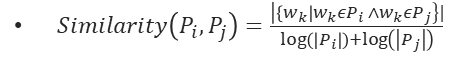

##### Example:

Text1:['carson', 'want', 'a', 'flat', 'tax']

Text2:['carson', 'wants', 'two', 'flat', 'taxes']

Similarity(Text1, Text2) = 2 / log(5)+log(5) = 0.6213

In [ ]:
# Compute similarity measure by Michalcea and Tarau (2004)

# Compute similarity matrix
sim_dict = {}
##### To do : implement the similarity measure #########

#######################################################    

# Print similarity matrix
sim = pd.DataFrame(sim_dict)

In [ ]:
# lets have a look at the similarity matrix
sim.head(20)

In [ ]:
# let us assure everybody got the same results
with open('similarity_assert.pkl', 'rb') as f: assert sim['173836'].tolist() == pickle.load(f).tolist()

#### Apply TextRank algo

In [ ]:
# Transform the dataframe into a n-dimensional Numpy-array
sim_matrix = sim.values

# TextRank
nx_graph = nx.from_numpy_array(sim_matrix)
scores = nx.pagerank(nx_graph)

# Sort TextRank Scores
sorted_scores_Common_words = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

In [ ]:
#get the best 5 central texts
for i in range(5):
    node_ID = sorted_scores_Common_words[i][0]
    id_ = sim.index[node_ID]
    print(df.text[df.index[df.index == id_][0]])
    print('----------------------------------------')

-----------------------------------

## 2. Centrality computed by word2vec for increased performance.
-----------------------------------


#### Creating the Word2Vec model

##### What is doc2vec and how does it work?
Word2vec represents the meaning of words and their relations in vector space, making every word become a feature vector. What this allows us to do is to derive related words from a specific word. A classic example you probably already know is the "king"-example. It basically tells that king is to queen what men is to women.

![alt text](kingqueen.png)

In [ ]:
# Load vectors directly from the file
model = KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin', binary=True)

In this step we want to compare all texts using the cosine similarity measure. Since word2vec only gives us vectors for each word we have to create the document vectors on our own.

__Your tasks are:__
1. To compute the similarity between each pair of texts, we compute the centroids of each text. 
2. The centroid of a text is the average of all its token vectors.


In [ ]:
centroids = []
##### To do : compute the centroids for each text #########

#######################################################
df["w2v_centorids"] = centroids

In [ ]:
# lets have a look at the centroids
df.head()

Now that we have our document vecors, we can compute the cosine similarity of each document pair.

__Your tasks are:__
1. The centroids are then compared using cosine similarity.

In [ ]:
# Compute consine similarity

# Compute similarity matrix
sim_dict = {}
##### To do : implement the similarity measure #########

#######################################################    

# Print similarity matrix
sim = pd.DataFrame(sim_dict)

In [ ]:
# lets have a look at the similarity matrix
sim.head(20)

In [ ]:
# replace nan values with 0
sim = sim.fillna(0)

In [ ]:
# let us assure everybody got the same results
with open('w2v_assert.pkl', 'rb') as g: assert sim['173836'].tolist() == pickle.load(g).tolist()

#### Apply TextRank algo

In [ ]:
# Transform the dataframe into a n-dimensional Numpy-array
sim_matrix = sim.values

# TextRank
nx_graph = nx.from_numpy_array(sim_matrix)
scores = nx.pagerank(nx_graph)

# Sort TextRank Scores
sorted_scores_word2vec = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

In [ ]:
#get the best 5 central texts
for i in range(5):
    node_ID = sorted_scores_word2vec[i][0]
    id_ = sim.index[node_ID]
    print(df.text[df.index[df.index == id_][0]])
    print('----------------------------------------')

-----------------------------------

## 3. Evaluating the computed centrality

In this part we will:
1. Computing the centrality based on the graph structure <br>
2. Computing Kendalls rank correlation <br>

To obtain the ground truth results based on the centrality measure represented in the lecture, we need to recreate the original graph from the data. However for our purpose only reasoning-nodes(RA) and conflict-nodes(CA) are of relevance.

__Hint:__ You can think of RA-nodes as support and CA-nodes as attacks towards an argument.

In [ ]:
# read in the nodesets
#choose nodes which are supporting or conflict nodes and safe the node where the edge comes from
directory = os.path.join(os.getcwd(),'US2016R1reddit')
interesting_nodes = {}
nodeID = 0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".json"):
        with open(os.path.join(directory,filename), 'r') as json_file:
            json_data = json.load(json_file)
            for i in range(len(json_data['nodes'])):
                edges = []
                if json_data['nodes'][i]['type'] == "CA" or json_data['nodes'][i]['type'] == "RA" :
                    nodeID = json_data['nodes'][i]['nodeID'] 
                for j in range (len(json_data['edges'])):
                        if json_data['edges'][j]['toID'] == nodeID:
                            edges.append(json_data['edges'][j]['fromID'])
                            interesting_nodes [nodeID] = edges
    else:
        continue

In [ ]:
# lets have a look at the graph, values are outgoing edges
print(interesting_nodes)

##### Now that we have the data prepared we can compute the centrality measurement for all nodes.

In [ ]:
#building up a graph from what we found out ready to do computation of centrality 
list_of_nodes = []
list_of_edges = []
for key, value in interesting_nodes.items():
    list_of_nodes.append(key)
    list_of_nodes.extend(value)
    for i in range(len(value)):
        edge = (value[i],key)
        list_of_edges.append(edge)

#actually build up the sub graph by using Networkx libary   
sub_graph=nx.Graph()
sub_graph.add_nodes_from(list_of_nodes)
sub_graph.add_edges_from(list_of_edges)

# compute centrality
centrality = nx.eigenvector_centrality(sub_graph, max_iter=500, tol=1e-06, nstart=None, weight='weight')

# delete support and attack nodes
for key, value in interesting_nodes.items():
    del centrality[key]

sorted_scores_onGraph = sorted(centrality.items(), key=operator.itemgetter(1), reverse = True)

##### The next step is to map the ranking back to the original nodes in the dataframe.

In [ ]:
# map the ranking back to the original instances in the df
ranking = [i[0] for i in sorted_scores_onGraph]
centrality_rankings = []
for row in df.iterrows():
    try:
        centrality_rankings.append(ranking.index(row[0]))
    except:
        centrality_rankings.append(1173)
        
df['centrality_ranking'] = centrality_rankings

In [ ]:
# map the ranking back to the original instances in the df
list_w2v = []
for i in range(len(sorted_scores_word2vec)):
    list_w2v.append(sim.index[sorted_scores_word2vec[i][0]])

w2v_rankings = []
for row in df.iterrows():
    try:
        w2v_rankings.append(list_w2v.index(row[0]))
    except:
        w2v_rankings.append(1173)
        
df['word2vec_ranking'] = w2v_rankings

In [ ]:
# map the ranking back to the original instances in the df
list_cw = []
for i in range(len(sorted_scores_Common_words)):
    list_cw.append(sim.index[sorted_scores_Common_words[i][0]])
    
common_words_rankings = []
for row in df.iterrows():
    try:
        common_words_rankings.append(list_cw.index(row[0]))
    except:
        common_words_rankings.append(1173)
        
df['common_words_ranking'] = common_words_rankings

In [ ]:
# lets have a look at our final dataframe
df.head(20)

##### After we've computed the ground truth centrality we can now compare our text based algorithms. 
To do this we use Kendalls rank correlation.

In [ ]:
#compute kendalls tau for rank correlation onGraph and ranking_Common_word
kendalls_tau, p_value = stats.kendalltau(df['centrality_ranking'], df['common_words_ranking'])
print(kendalls_tau)

In [ ]:
#compute kendalls tau for rank correlation onGraph and ranking_Common_word
kendalls_tau, p_value = stats.kendalltau(df['centrality_ranking'], df['word2vec_ranking'])
print(kendalls_tau)